In [ ]:
# default_exp pseudodata

# pseudodata

> API details.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
# export
from fastcore.all import store_attr
from typing import Callable, Tuple, Union, List
import numpy as np
import pandas as pd

In [ ]:
# export
class PseudoData():
    def __init__(self, func:Callable[[int],np.ndarray], targ:Union[float,int]): store_attr()
    def __getitem__(self, i:int) -> Tuple[np.ndarray,np.ndarray]: self.sample(1)
    def sample(self, n:int) -> Tuple[np.ndarray,np.ndarray,None]:
        return self.func(n).astype('float32'),self.targ*np.ones((n,1)).astype('float32'),None
    def get_df(self, n:int) -> pd.DataFrame:
        df = pd.DataFrame(np.hstack(self.sample(n)))
        df.rename(columns={df.columns[-1]:'gen_target'}, inplace=True)
        return df

In [ ]:
d = PseudoData(lambda x: np.random.normal(0,1,(x,3)), 0)
df = d.get_df(10)
assert df.values.shape == (10,4)
df.head()

,0,1,2,gen_target
0,-1.411814,0.362887,-0.791763,0.0
1,-1.589670,-0.971194,-1.143807,0.0
2,-2.096816,-0.650274,0.961579,0.0
3,-1.970664,-0.932901,1.019038,0.0
4,-0.448117,1.300067,0.167887,0.0


## INFERNO paper

In [ ]:
# export
class _PaperData():
    def __init__(self, mu:List[float], conv:List[List[float]], r:float, l:float):
        store_attr(but=['mu', 'r'])
        self.r = np.array([r,0])
        self.mu = np.array(mu)
        
    def __call__(self, n:int) -> np.ndarray:
        return np.hstack((np.random.multivariate_normal(self.mu+self.r, self.conv, n),
                          np.random.exponential(self.l, size=n)[:,None]))

In [ ]:
# export
paper_sig = _PaperData([0,0], [[1,0],[0,1]], 0, 2)

In [ ]:
s0 = paper_sig(2)
print(s0)
assert s0.shape == (2,3)

[[0.81797187 2.11891124 1.65196733]
 [0.37336495 0.85988937 1.07779935]]


In [ ]:
paper_sig1 = _PaperData([1,1], [[1,0],[0,1]], 0, 2)
paper_sig1.r[0] += 1000

In [ ]:
s1 = paper_sig(2)
print(s1)
assert s1[0,0] > s0[0,0]

[[2.01104081 0.25435085 2.67243952]
 [1.3537871  2.46336116 3.57245009]]


In [ ]:
# export
paper_bkg_bm0 = _PaperData([2,0], [[5,0],[0,9]], 0, 3)

### Check

In [ ]:
n=1000
df = PseudoData(paper_sig, 1).get_df(n).append(PseudoData(paper_bkg_bm0, 0).get_df(n), ignore_index=True)
df

,0,1,2,gen_target
0,1.619847,-0.975604,4.646335,1.0
1,-0.693220,-0.066585,1.166957,1.0
2,0.380253,0.181375,2.737681,1.0
3,0.325826,-0.250597,1.039776,1.0
4,-1.019976,0.105535,2.954149,1.0
...,...,...,...,...
1995,-1.208189,-2.563646,2.212983,0.0
1996,6.899484,-0.900567,0.043735,0.0
1997,1.184163,-1.523233,5.998018,0.0
1998,1.664247,1.823261,0.021460,0.0


/Users/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


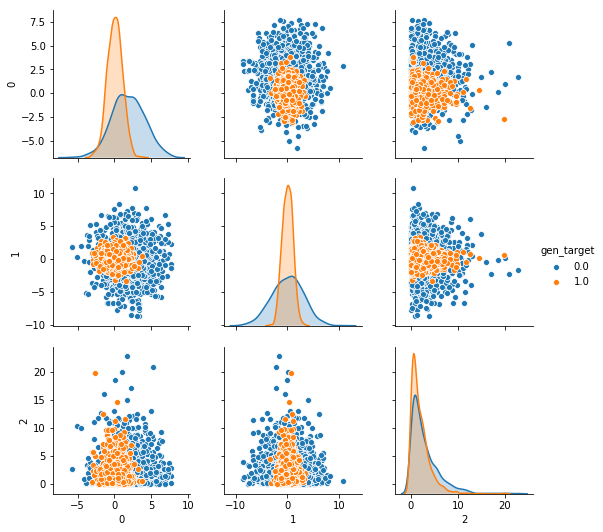

In [ ]:
import seaborn as sns
sns.pairplot(df, hue='gen_target', vars=[f for f in df.columns if f != 'gen_target'])

### Other benchmarks